# Categorical Regression

This notebook is part of a tutorial on "Practical Bayesian Modeling with PyMC"

[Click here to run this notebook on Colab](https://colab.research.google.com/github/AllenDowney/SurveyDataPyMC/blob/main/notebooks/02_categorical_regression.ipynb)

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Get utils.py

from os.path import basename, exists

def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve

        local, _ = urlretrieve(url, filename)
        print("Downloaded " + local)

download("https://github.com/AllenDowney/SurveyDataPyMC/raw/main/notebooks/utils.py")

Downloaded utils.py


In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import arviz as az

from utils import value_counts, decorate, load_idata_or_sample

In [4]:
# Make the figures smaller to save some screen real estate
plt.rcParams["figure.dpi"] = 75
plt.rcParams["figure.figsize"] = [6, 3.5]
plt.rcParams["axes.titlelocation"] = "left"

## Data

The dataset we'll use is an extract from the General Social Survey.
The following cell downloads it.

In [5]:
# This dataset is prepared in GssExtract/notebooks/02_make_extract-2022_4.ipynb
# It has been resampled to correct for stratified sampling

DATA_PATH = "https://github.com/AllenDowney/GssExtract/raw/main/data/interim/"
filename = "gss_extract_2022_4.hdf"
download(DATA_PATH + filename)

Downloaded gss_extract_2022_4.hdf


In [6]:
gss = pd.read_hdf(filename, "gss")
gss.columns

Index(['age', 'attend', 'ballot', 'class', 'clmtcaus', 'clmtusa', 'clmtwrld',
       'cohort', 'commun', 'conarmy', 'conbus', 'conclerg', 'coneduc',
       'confed', 'confinan', 'coninc', 'conjudge', 'conlabor', 'conlegis',
       'conmedic', 'conpress', 'conrinc', 'consci', 'contv', 'degree', 'educ',
       'eqwlth', 'fair', 'fear', 'fund', 'goodlife', 'hapmar', 'happy',
       'health', 'helpful', 'id', 'life', 'partyid', 'polviews', 'pres16',
       'pres20', 'race', 'realinc', 'realrinc', 'reg16', 'region', 'relig',
       'relig16', 'reliten', 'res16', 'rincome', 'satfin', 'satjob', 'sex',
       'sexbirth', 'sexbirth1', 'sexnow', 'sexnow1', 'srcbelt', 'trust',
       'wtssall', 'year'],
      dtype='object')

## Categorical Regression

In a categorical regression model, the dependent variable is discrete and unordered.

As an example, we'll consider responses to [this question](https://gssdataexplorer.norc.org/variables/7759/vshow), asked in 2022 related to the 2020 presidential election.

> Did you vote for Joe Biden or Donald Trump?

```
1 Biden
2 Trump
3 Other
4 Didn't vote
```

For respondents from prior to 2022, the value of this variable is NaN.

In [7]:
value_counts(gss["pres20"])

,counts
values,
1.0,1259
2.0,946
3.0,96
4.0,16
NaN,70073


In addition, we'll treat "Didn't vote" as missing data -- although another option would be to treat it as a fourth category.

In [8]:
gss["y"] = gss["pres20"].replace({3: 0, 4: np.nan})
value_counts(gss["y"])

,counts
values,
0.0,96
1.0,1259
2.0,946
NaN,70089


The following dictionary maps from response codes to strings.

In [9]:
vote_map = {
    0: "Other",
    1: "Biden",
    2: "Trump",
}

We'll use age as a predictor.
In the regression model, we'll treat age as a continuous variable, but to plot the data, we'll group ages into 5-year bins.

In [10]:
from utils import round_into_bins

gss["age_group"] = round_into_bins(gss["age"].copy(), 5, low=13) + 2

The following table show the percentage of respondents in each age group who gave each responses.

In [11]:
table = pd.crosstab(gss["age_group"], gss["y"], normalize="index") * 100
table = table.rename(columns=vote_map)
table

y,Other,Biden,Trump
age_group,,,
20.0,0.680272,61.224490,38.095238
25.0,9.859155,59.154930,30.985915
30.0,2.684564,74.496644,22.818792
35.0,3.816794,59.541985,36.641221
40.0,5.851064,39.893617,54.255319
45.0,7.222222,50.555556,42.222222
50.0,4.149378,48.962656,46.887967
55.0,5.747126,56.896552,37.356322
60.0,3.255814,53.953488,42.790698


And here's what those results look like.

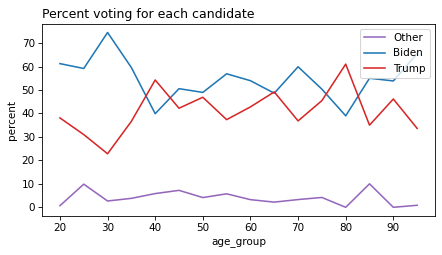

In [12]:
colors = ["C4", "C0", "C3"]
table.plot(color=colors)
decorate(ylabel="percent", title="Percent voting for each candidate")

It looks like younger people were more likely to vote for Biden, and older people were more likely to vote for Trump.
There is no obvious relationship between age and voting for a third-party candidate.

## Categorical Regression

Now let's make a regression model that estimates the probability of voting for each candidate as a function of age.
We'll select the subset of the data with valid responses.

In [13]:
data = gss.dropna(subset=["y", "age"])
data.shape

(2185, 64)

And we'll extract the values as NumPy arrays.
As we did with `year` in the previous notebook, we'll center the ages.

In [14]:
y = data["y"].values
age = data["age"].values

# Center age
age_shift = age.mean()
age_centered = age - age_shift

Now, we'll build the regression model.

The assumption of categorical regression is that each respondent has a latent propensity to vote for each of the candidates, which is represented on a log odds scale.

The zero-point of this scale is arbitrary, so we'll choose propensity for "Other" as the reference point and estimate coefficients for Biden and Trump relative to Other.

To map from these logits to probabilities, we'll use the `softmax` function, which is a generalization of the `expit` function we used for logistic regression.

Here's the `expit` function:

$$
\text{expit}(x) = \frac{1}{1 + e^{-x}}
$$

This maps a single log-odds value \( x \) to a probability between 0 and 1.


And here's the `softmax` function:

$$
\text{softmax}(x_i) = \frac{e^{x_i}}{\sum_{j} e^{x_j}}
$$

This maps a set of logits $(x_1, x_2, \ldots, x_n)$ to a set of probabilities that sum to 1, assigning higher probabilities to larger logits.

Once we have probabilities we can compute the likelihood of the data with `Categorical`, which is the generalization of `Bernoulli` to more than two outcomes.

In [16]:
# Modify this

with pm.Model() as categorical_model:
    alpha = pm.Normal("alpha", 0, 1, shape=2)        # Biden, Trump (relative to Other)
    beta_age = pm.Normal("beta_age", 0, 1, shape=2)

    logit_other = np.zeros(len(age))
    logit_biden = alpha[0] + beta_age[0]*age_centered
    logit_trump = alpha[1] + beta_age[1]*age_centered

    logits = pm.math.stack([logit_other,logit_biden,logit_trump],axis=1)

    p = pm.math.softmax(logits, axis=1)

    y_obs = pm.Categorical("y_obs", p=p, observed=y)

In [18]:
# Solution

with pm.Model() as categorical_model:
    alpha = pm.Normal("alpha", 0, 1, shape=2)        # Biden, Trump (relative to Other)
    beta_age = pm.Normal("beta_age", 0, 1, shape=2)

    logit_other = np.zeros(len(age))
    logit_biden = alpha[0] + beta_age[0] * age_centered
    logit_trump = alpha[1] + beta_age[1] * age_centered

    logits = pm.math.stack([logit_other, logit_biden, logit_trump], axis=1)

    p = pm.math.softmax(logits, axis=1)

    y_obs = pm.Categorical("y_obs", p=p, observed=y)

Here's what the model looks like.

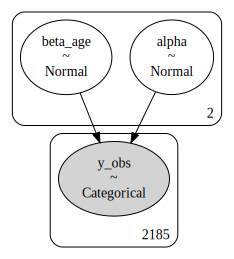

In [19]:
pm.model_to_graphviz(categorical_model)

Here's how we can sample it.

In [20]:
filename = 'categorical_model_idata.nc'
idata_categorical = load_idata_or_sample(categorical_model, filename, draws=500, tune=500)

Output()

Saved new idata to categorical_model_idata.nc


The traces and diagnostic summary look good.

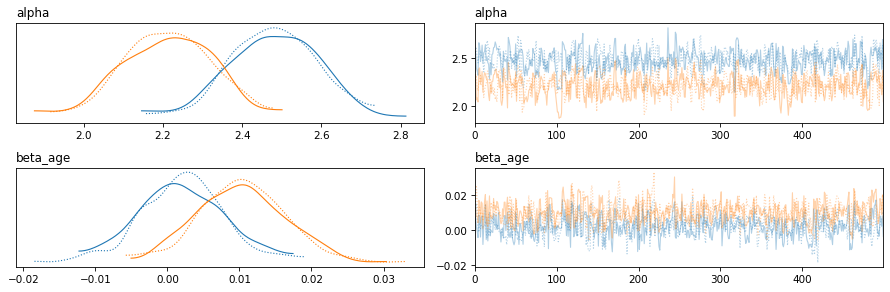

In [21]:
az.plot_trace(idata_categorical)
decorate()

In [22]:
az.summary(idata_categorical)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha[0],2.479,0.111,2.298,2.699,0.005,0.004,540.0,374.0,1.01
alpha[1],2.212,0.113,2.008,2.419,0.005,0.004,520.0,352.0,1.00
beta_age[0],0.002,0.006,-0.009,0.014,0.000,0.000,511.0,456.0,1.00
beta_age[1],0.010,0.006,-0.002,0.021,0.000,0.000,527.0,474.0,1.00


And here's what the posterior distribution looks like.

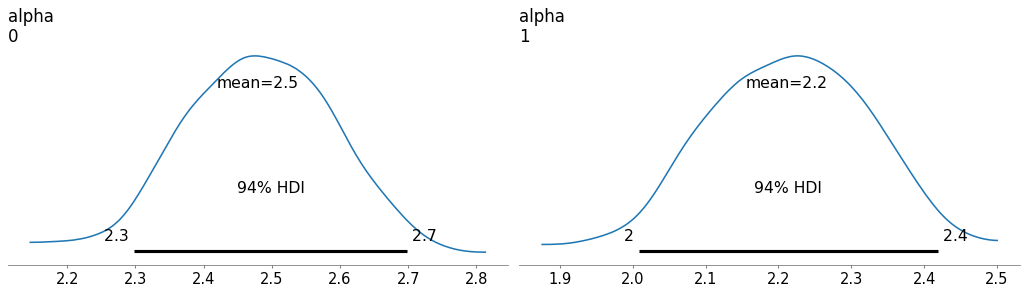

In [23]:
az.plot_posterior(idata_categorical, var_names=["alpha"])
decorate()

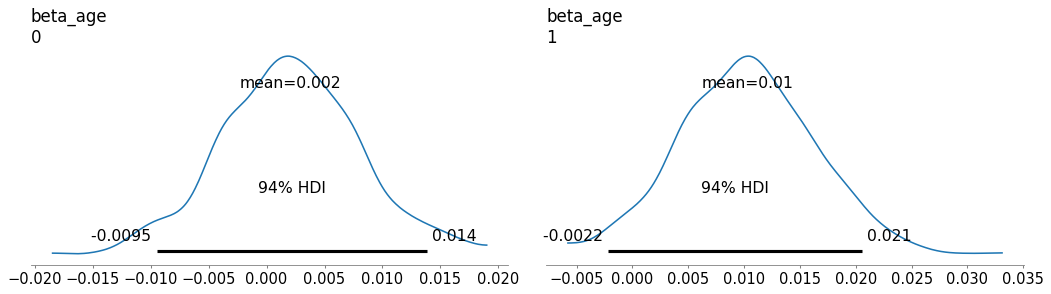

In [24]:
az.plot_posterior(idata_categorical, var_names=["beta_age"])
decorate()

The posterior distribution contains two values for `alpha` and `beta_age`, one for Biden relative to Other and one for Trump relative to Other.

## Interpreting the results

We can use `az.extract` to combine the chains and select a random subsample of the posterior samples.

In [25]:
# Collect posterior draws of alpha and beta
n_samples = 100
samples = az.extract(idata_categorical,
                     var_names=["alpha", "beta_age"],
                     num_samples=n_samples)

alpha = samples["alpha"].to_numpy()
alpha.shape

(2, 100)

In [26]:
beta_age = samples["beta_age"].to_numpy()
beta_age.shape

(2, 100)

Now, to visualize the results, we'll evaluate the regression equation over a range of ages.

In [27]:
# Center the age range
pred_age_range = np.arange(18, 95)
pred_age_centered = pred_age_range - age_shift
n_ages = len(pred_age_range)

To evaluate the predictive probabilities for each age, we'll implement the model in NumPy.

In [28]:
from scipy.special import softmax

predicted_probs = np.zeros((n_samples, n_ages, 3))

for i in range(n_samples):
    logit_other = np.zeros(n_ages)  # Fixed at zero for reference category
    logit_biden = alpha[0, i] + beta_age[0, i] * pred_age_centered
    logit_trump = alpha[1, i] + beta_age[1, i] * pred_age_centered

    logits = np.stack([logit_other, logit_biden, logit_trump], axis=1)

    # Softmax to get probabilities for all candidates at each age
    predicted_probs[i] = softmax(logits, axis=1)

Here's what the result look like.

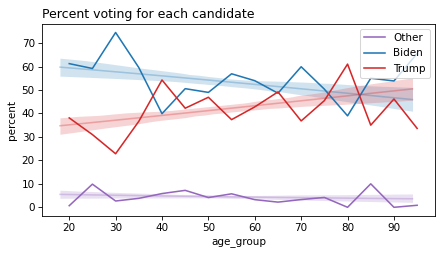

In [29]:
table.plot(color=colors)

for i, name in vote_map.items():
    mean_prob = predicted_probs[:, :, i].mean(axis=0)
    hdi_low, hdi_high = np.percentile(predicted_probs[:, :, i], [5, 95], axis=0)

    plt.plot(pred_age_range, mean_prob * 100, color=colors[i], alpha=0.3)
    plt.fill_between(pred_age_range,
                     hdi_low * 100,
                     hdi_high * 100,
                     color=colors[i],
                     alpha=0.2,
                     lw=0)

decorate(ylabel="percent", title="Percent voting for each candidate")

It looks like the regression model does a good job of capturing the trends in the data.

We can use these results to estimate the crossover point -- the age below which people were more likely to vote for Biden.

## Adding a categorical predictor

Now let's see what the interaction looks like between age and gender.

[Note from GSS documentation](https://sda.berkeley.edu/sdaweb/docs/gss21/DOC/2021XSECR1MethodologicalPrimer.pdf):

> In the past, GSS respondents have not been asked to self-report their sex. Instead, the GSS used a combination of interviewer observation and household rosters for the variable SEX, our standard male/female variable. In 2021, as neither household roster nor interviewer observation were available, respondents were directly asked two questions: their sex assigned at birth and their current gender identity. These two items, SEXBIRTH1 and SEXNOW1, are now the standard way of measuring sex in the GSS]

Here is the question and responses.

> Do you describe yourself as male, female, or transgender?

```
1	Male
2	Female
3	Transgender
4	None of these
```

Here is the distribution of the responses.

In [30]:
value_counts(gss["sexnow1"])

,counts
values,
1.0,3620
2.0,3743
3.0,19
4.0,37
NaN,64971


In [ ]:
pd.crosstab(gss['sexnow1'], gss['sexbirth1'])

For this example, we will limit the analysis to people who identify as male or female.
As an aside, a hierarchical model would be a good way to conduct this analysis with all gender groups.

In [ ]:
gss['gender2'] = gss['sexnow1'].replace([3, 4], np.nan)

Now we'll prepare the data for use in the model.

In [ ]:
data = gss.dropna(subset=["y", "age", "gender2"])
data.shape

In [ ]:
y = data["y"].to_numpy()
age = data["age"].to_numpy()
gender = data["gender2"].to_numpy()

In [ ]:
# Center age
age_shift = age.mean()
age_centered = age - age_shift

# Recode gender to 0 = male, 1 = female
gender = (gender == 2).astype(int)

And here's the model with gender as an additional categorical predictor.

In [ ]:
# Modify this

with pm.Model() as categorical_model:
    alpha = pm.Normal("alpha", 0, 1, shape=2)
    beta_age = pm.Normal("beta_age", 0, 1, shape=2)

    logit_other = np.zeros(len(age))
    logit_biden = alpha[0] + beta_age[0] * age_centered
    logit_trump = alpha[1] + beta_age[1] * age_centered

    logits = pm.math.stack([logit_other, logit_biden, logit_trump], axis=1)

    p = pm.math.softmax(logits, axis=1)

    y_obs = pm.Categorical("y_obs", p=p, observed=y)

In [ ]:
# Solution

with pm.Model() as categorical_model2:
    # Biden, Trump (relative to Other)
    alpha = pm.Normal("alpha", 0, 1, shape=2)

    # Slopes for age (Biden, Trump)
    beta_age = pm.Normal("beta_age", 0, 1, shape=2)

    # Slopes for gender (Biden, Trump)
    beta_gender = pm.Normal("beta_gender", 0, 1, shape=2)

    # Compute logits for each party across all respondents
    logit_other = np.zeros(len(age))
    logit_biden = alpha[0] + beta_age[0] * age_centered + beta_gender[0] * gender
    logit_trump = alpha[1] + beta_age[1] * age_centered + beta_gender[1] * gender

    logits = pm.math.stack([logit_other, logit_biden, logit_trump], axis=1)

    p = pm.math.softmax(logits, axis=1)

    y_obs = pm.Categorical("y_obs", p=p, observed=y)

In [ ]:
pm.model_to_graphviz(categorical_model2)

In [ ]:
filename = 'categorical_model2_idata.nc'
idata_categorical2 = load_idata_or_sample(categorical_model2,
                                          filename, draws=500, tune=500)

In [ ]:
az.plot_trace(idata_categorical2)
decorate()

In [ ]:
az.summary(idata_categorical2)

In [ ]:
az.plot_posterior(idata_categorical2)
decorate()

## Plotting the results

Again, we'll use `az.extract` to get a sample from the posterior.

In [ ]:
# Collect posterior draws of alpha and beta
n_samples = 100
samples = az.extract(idata_categorical2,
                     var_names=["alpha", "beta_age", "beta_gender"],
                     num_samples=n_samples)

alpha = samples["alpha"].to_numpy()
alpha.shape

In [ ]:
beta_age = samples["beta_age"].to_numpy()
beta_age.shape

In [ ]:
beta_gender = samples["beta_gender"].to_numpy()
beta_gender.shape

With more predictors, it's a little more complicated to plot the results, but there's nothing conceptually new here.

In [ ]:
def compute_predicted_probs(alpha, beta_age, beta_gender, age_centered, gender):
    """Compute predicted probabilities for a given gender (0=male, 1=female).

    alpha: array of shape (2, n_samples)
    beta_age: array of shape (2, n_samples)
    beta_gender: array of shape (2, n_samples)
    age_centered: array of centered ages
    gender: 0 for male, 1 for female

    returns: array of shape (n_samples, n_ages, 3) with predicted probabilities in percent
    """
    n_samples = alpha.shape[1]
    n_ages = len(age_centered)

    predicted_probs = np.zeros((n_samples, n_ages, 3))

    for i in range(n_samples):
        logit_other = np.zeros(n_ages)
        logit_biden = (alpha[0, i] +
                       beta_age[0, i] * age_centered +
                       beta_gender[0, i] * gender)
        logit_trump = (alpha[1, i] +
                       beta_age[1, i] * age_centered +
                       beta_gender[1, i] * gender)

        logits = np.stack([logit_other, logit_biden, logit_trump], axis=1)
        predicted_probs[i] = softmax(logits, axis=1) * 100

    return predicted_probs

In [ ]:
predicted_probs_male = compute_predicted_probs(
    alpha, beta_age, beta_gender, pred_age_centered, gender=0
)
predicted_probs_male.shape

In [ ]:
predicted_probs_female = compute_predicted_probs(
    alpha, beta_age, beta_gender, pred_age_centered, gender=1
)
predicted_probs_female.shape

In [ ]:
def plot_predictions_by_gender(age_range, predicted_probs, ls="-"):
    """Plot predicted probabilities for one gender (male or female).

    age_range: array of ages to plot
    predicted_probs: array of shape (n_samples, n_ages, 3)
    ls: string for matplotlib line style
    """
    for i, name in vote_map.items():
        probs = predicted_probs[:, :, i]
        mean_prob = probs.mean(axis=0)
        hdi_low, hdi_high = np.percentile(probs, [5, 95], axis=0)

        plt.plot(
            age_range,
            mean_prob,
            color=colors[i],
            alpha=0.5,
            ls=ls,
        )
        plt.fill_between(
            age_range,
            hdi_low,
            hdi_high,
            color=colors[i],
            alpha=0.1,
            lw=0,
        )

Here's what the results look like.

In [ ]:
table.plot(color=colors)

plot_predictions_by_gender(pred_age_range, predicted_probs_male, ls="--")
plot_predictions_by_gender(pred_age_range, predicted_probs_female, ls="-")

decorate(ylabel="percent", title="Percent voting for each candidate by age and gender")

At all ages, women were more likely to vote for Biden and less likely to vote for Trump.
For third-party candidate, there is no clear gender gap.